## Setup

In [1]:
import pandas as pd
import numpy as np 
import re
from jupyterthemes import jtplot
jtplot.style()

In [2]:
# load raw data
df = pd.read_csv('nuforc_reports.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141261 entries, 0 to 141260
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   summary         141189 non-null  object 
 1   country         140944 non-null  object 
 2   city            140783 non-null  object 
 3   state           131681 non-null  object 
 4   date_time       138601 non-null  object 
 5   shape           134962 non-null  object 
 6   duration        133645 non-null  object 
 7   stats           141261 non-null  object 
 8   report_link     141261 non-null  object 
 9   text            141227 non-null  object 
 10  posted          138601 non-null  object 
 11  city_latitude   115440 non-null  float64
 12  city_longitude  115440 non-null  float64
dtypes: float64(2), object(11)
memory usage: 14.0+ MB


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if type(text) != str:
        text = 'none'
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()

    # Remove stop words and lemmatize
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

def generate_text_features(df):
    df['cleaned_text'] = df['text'].apply(clean_text)
    df['cleaned_summary'] = df['summary'].apply(clean_text)
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
feature_df = generate_text_features(df)

## reduce sample size 

In [5]:
sample_df = feature_df.dropna(subset='city_latitude')
print(len(sample_df))
sample_df = sample_df.dropna(subset='shape')
print(len(sample_df))
sample_df = sample_df.dropna(subset='summary')
print(len(sample_df))
sample_df = sample_df.sample(50000)
print(len(sample_df))

115440
110411
110385
50000


First look at scoring topics via visual inspection and perplexity score (requires an unseen test set)

## LDA

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import pdb
import tqdm 

# convenience functions 
def run_trials(X, X_test, tfidf,
               alphas=[0.01, 0.1,  1, 2],
               betas=[0.01, 0.1, 0.5, 1],
               n_topics=[2, 3, 5, 10]):

    trials = []
    feature_names = tfidf.get_feature_names_out()
    
    for n in tqdm.tqdm(n_topics):
        for a in alphas:
            for b in betas:
                lda = LatentDirichletAllocation(n_components=n,
                                                random_state=42,
                                                doc_topic_prior=a, 
                                                topic_word_prior=b,
                                                learning_method='online',
                                                n_jobs=-1)
                # might crash if oom
                try:
                    lda.fit(X)
                except:
                    trials.append((a, b, n, -1))
                    continue
                    
                # score on unseen data
                perplexity = lda.perplexity(X_test)
                trials.append((a, b, n, perplexity))
    return trials

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx+1}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        
def plot_top_words(model, feature_names, n_top_words, title):
    nrows = 1+len(model.components_) // 6
    if len(model.components_) < 5:
        ncols = len(model.components_)
    else:
        ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        pdb.set_trace()
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}')
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show() 
    
def plot_best_model_from_trials(trials, tfidf, num_top_words=10, plot_top_n=3):
    for i in range(0, plot_top_n):
        a, b, n, p = pd.DataFrame(trials, columns = ['alpha', 'beta', 'n_components', 'perplexity']).sort_values('perplexity').iloc[i].astype('int')
        best_lda = LatentDirichletAllocation(n_components=n,
                                             random_state=42,
                                             doc_topic_prior=a, 
                                             topic_word_prior=b, 
                                             n_jobs=-1)
        best_lda.fit(X)
        feature_names = [str(x) for x in tfidf.get_feature_names_out()]
        plot_top_words(best_lda, feature_names, num_top_words, f'alpha: {a}, beta: {b}, n_components: {n}, perplexity: {p}')
        plt.show()
        

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
small_train_df, small_test_df = train_test_split(sample_df)
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(small_train_df.cleaned_summary)
X_test = tfidf.transform(small_test_df.cleaned_summary)
# lda alpha and beta priors for the dirichlet distribution
# high alpha = many topics
# low alpha = few topics
# high beta = many words per topic
# low beta = few words per topic
alphas = [0.1, 1]
betas = [0.005, 0.01]
n_topics = [6,7,8,9,10]
tfidf = TfidfVectorizer(stop_words=['light', 'bright', 'sky'])
X = tfidf.fit_transform(small_train_df.cleaned_summary)
X_test = tfidf.transform(small_test_df.cleaned_summary)

In [10]:
trials = run_trials(X, X_test, tfidf, alphas=alphas, betas=betas, n_topics=n_topics)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [40:02<00:00, 480.52s/it]


In [12]:
pd.DataFrame(trials, columns = ['alpha', 'beta', 'n_components', 'perplexity']).sort_values('perplexity')

,alpha,beta,n_components,perplexity
11,2.00,0.50,2,5.323170e+03
8,1.00,0.50,2,5.944435e+03
2,0.01,0.50,2,6.660641e+03
5,0.10,0.50,2,6.915342e+03
23,2.00,0.50,3,7.035114e+03
...,...,...,...,...
36,0.01,0.01,5,6.243650e+07
51,0.10,0.01,7,9.609441e+07
48,0.01,0.01,7,2.168098e+08
63,0.10,0.01,10,3.026744e+08


### 'light', 'bright', 'sky' are very common - removing these and rerunning analysis may provide additional insight

In [20]:
tfidf_stopwords = TfidfVectorizer(stop_words=['light', 'bright', 'sky'])
X = tfidf_stopwords.fit_transform(small_train_df.cleaned_summary)
X_test = tfidf_stopwords.transform(small_test_df.cleaned_summary)
trials = run_trials(X, X_test, tfidf_stopwords)

In [21]:
# results for trials after removing common terms
pd.DataFrame(trials, columns = ['alpha', 'beta', 'n_components', 'perplexity']).sort_values('perplexity')

,alpha,beta,n_components,perplexity
15,2.00,1.00,2,5.149335e+03
3,0.01,1.00,2,5.165431e+03
11,1.00,1.00,2,5.445439e+03
7,0.10,1.00,2,5.472392e+03
19,0.01,1.00,3,5.665723e+03
...,...,...,...,...
56,1.00,0.01,10,3.401837e+06
60,2.00,0.01,10,4.008118e+06
52,0.10,0.01,10,4.048313e+06
32,0.01,0.01,5,6.945027e+06


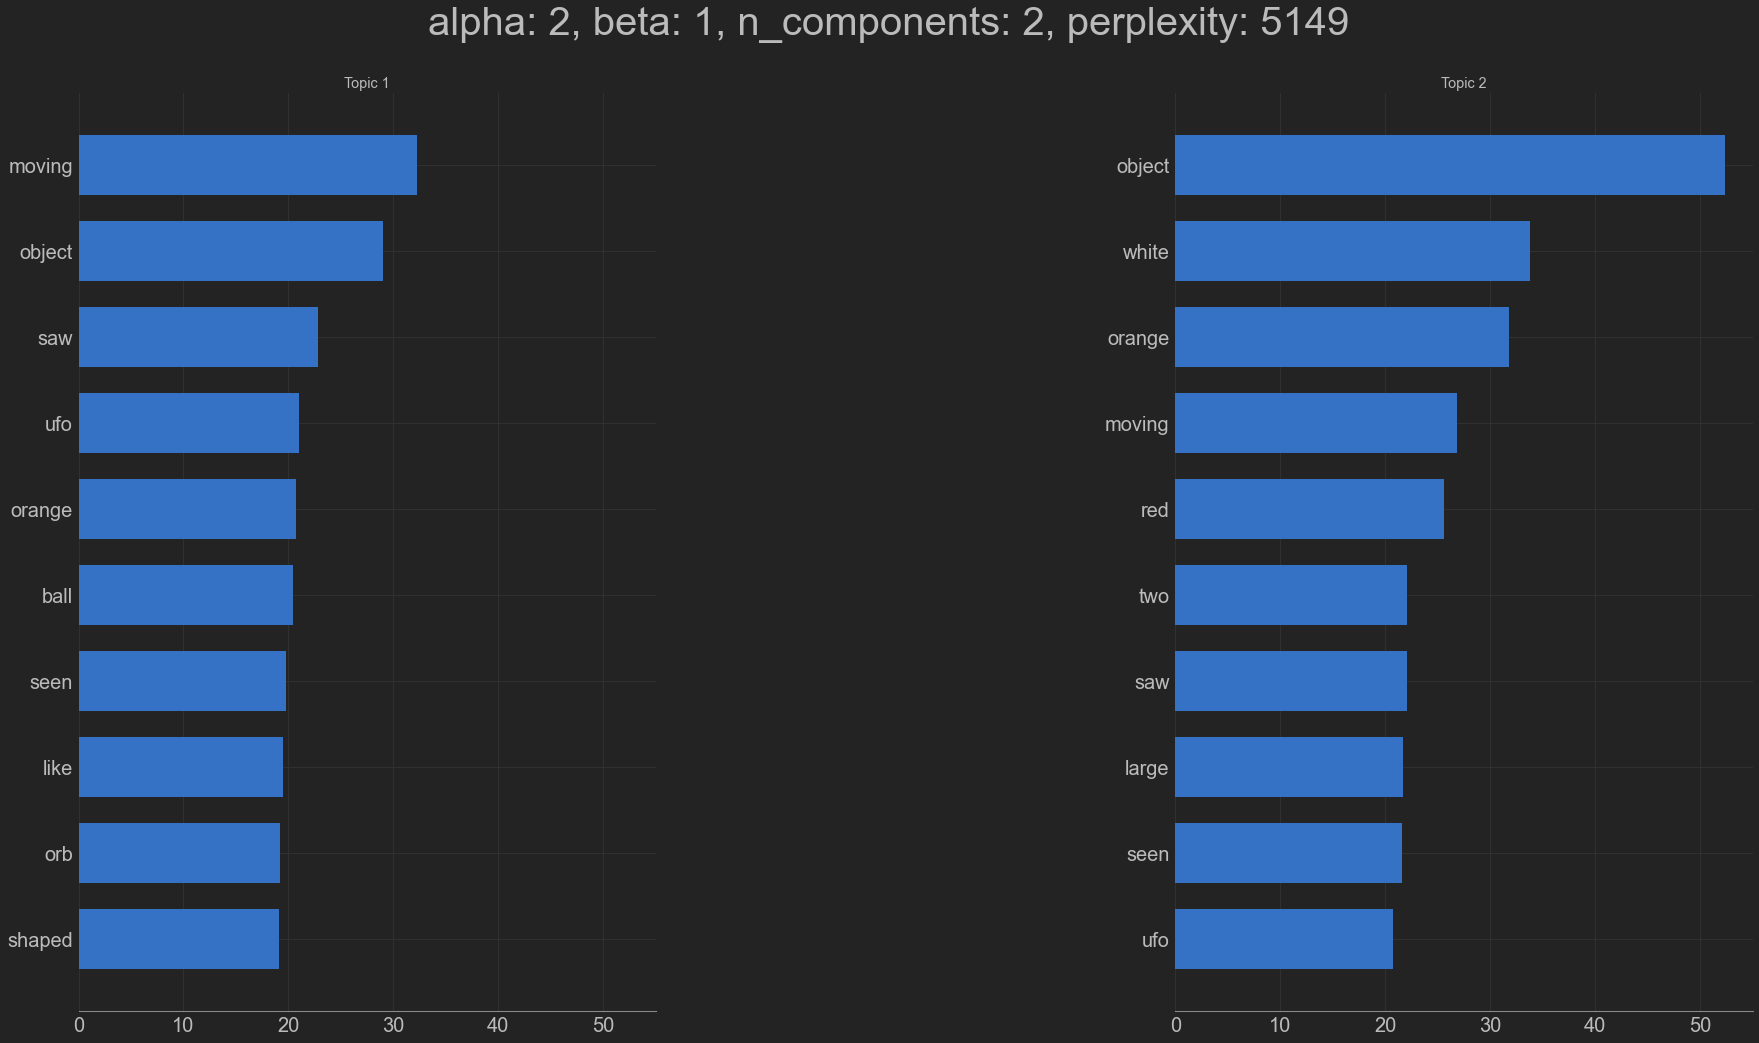

C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:745: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:746: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))


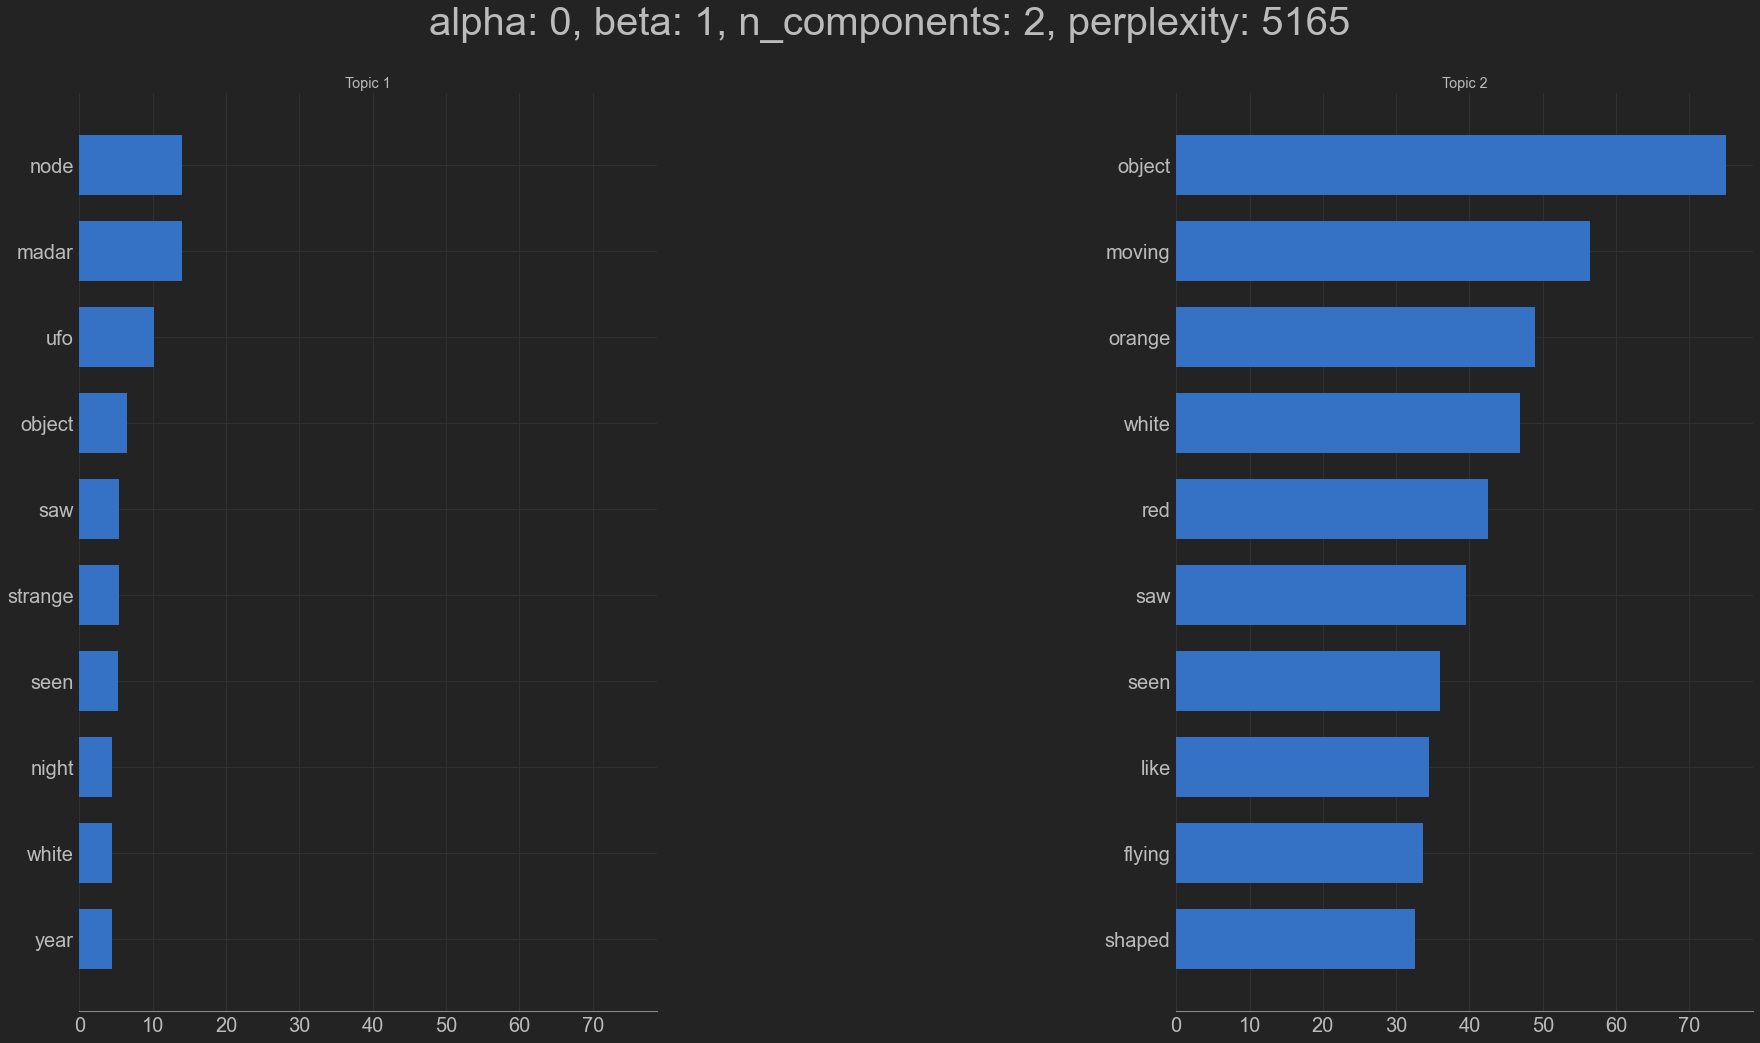

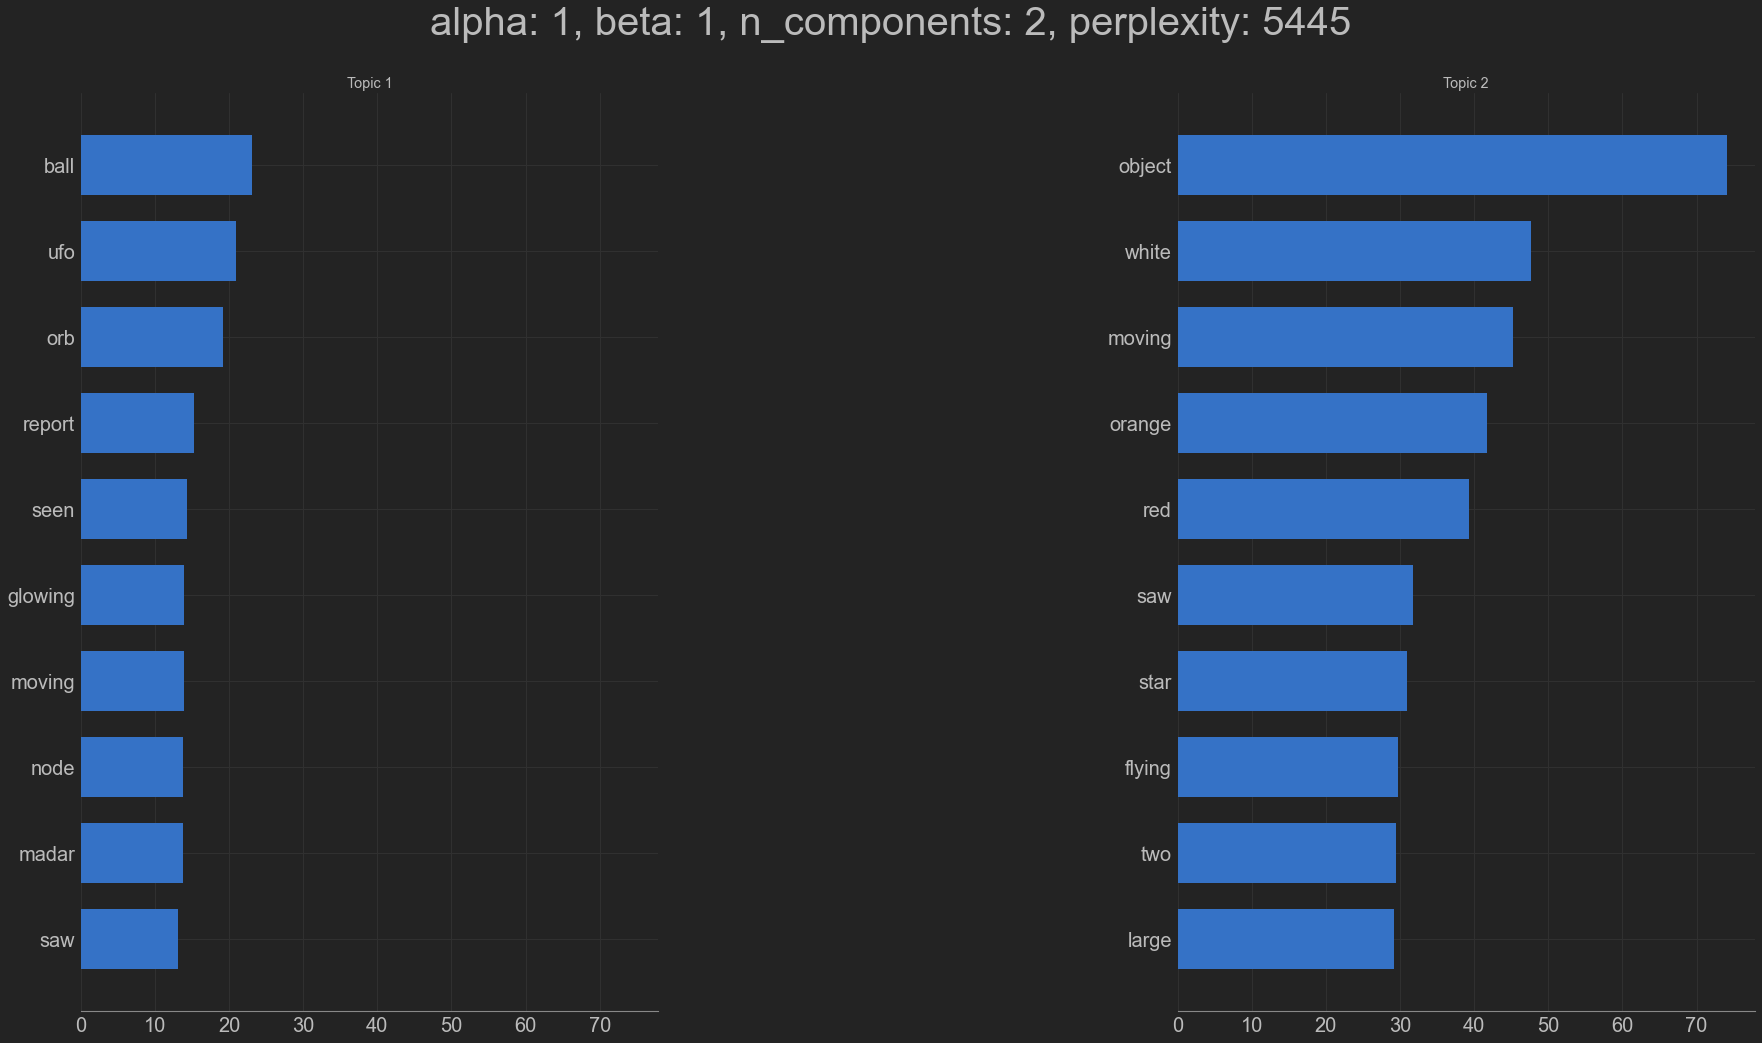

In [22]:
plot_best_model_from_trials(trials, tfidf_stopwords)

We can also extend to higher n-grams to incorporate common phrases

In [174]:
tfidf_bigrams = TfidfVectorizer(ngram_range=(1,2))
X = tfidf_bigrams.fit_transform(small_train_df.cleaned_summary)
X_test = tfidf_bigrams.transform(small_test_df.cleaned_summary)
feature_names = tfidf_bigrams.get_feature_names_out()
trials = run_trials(X, X_test, tfidf_bigrams)
pd.DataFrame(trials, columns = ['alpha', 'beta', 'n_components', 'perplexity']).sort_values('perplexity')

KeyboardInterrupt: 

C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:745: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:746: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))


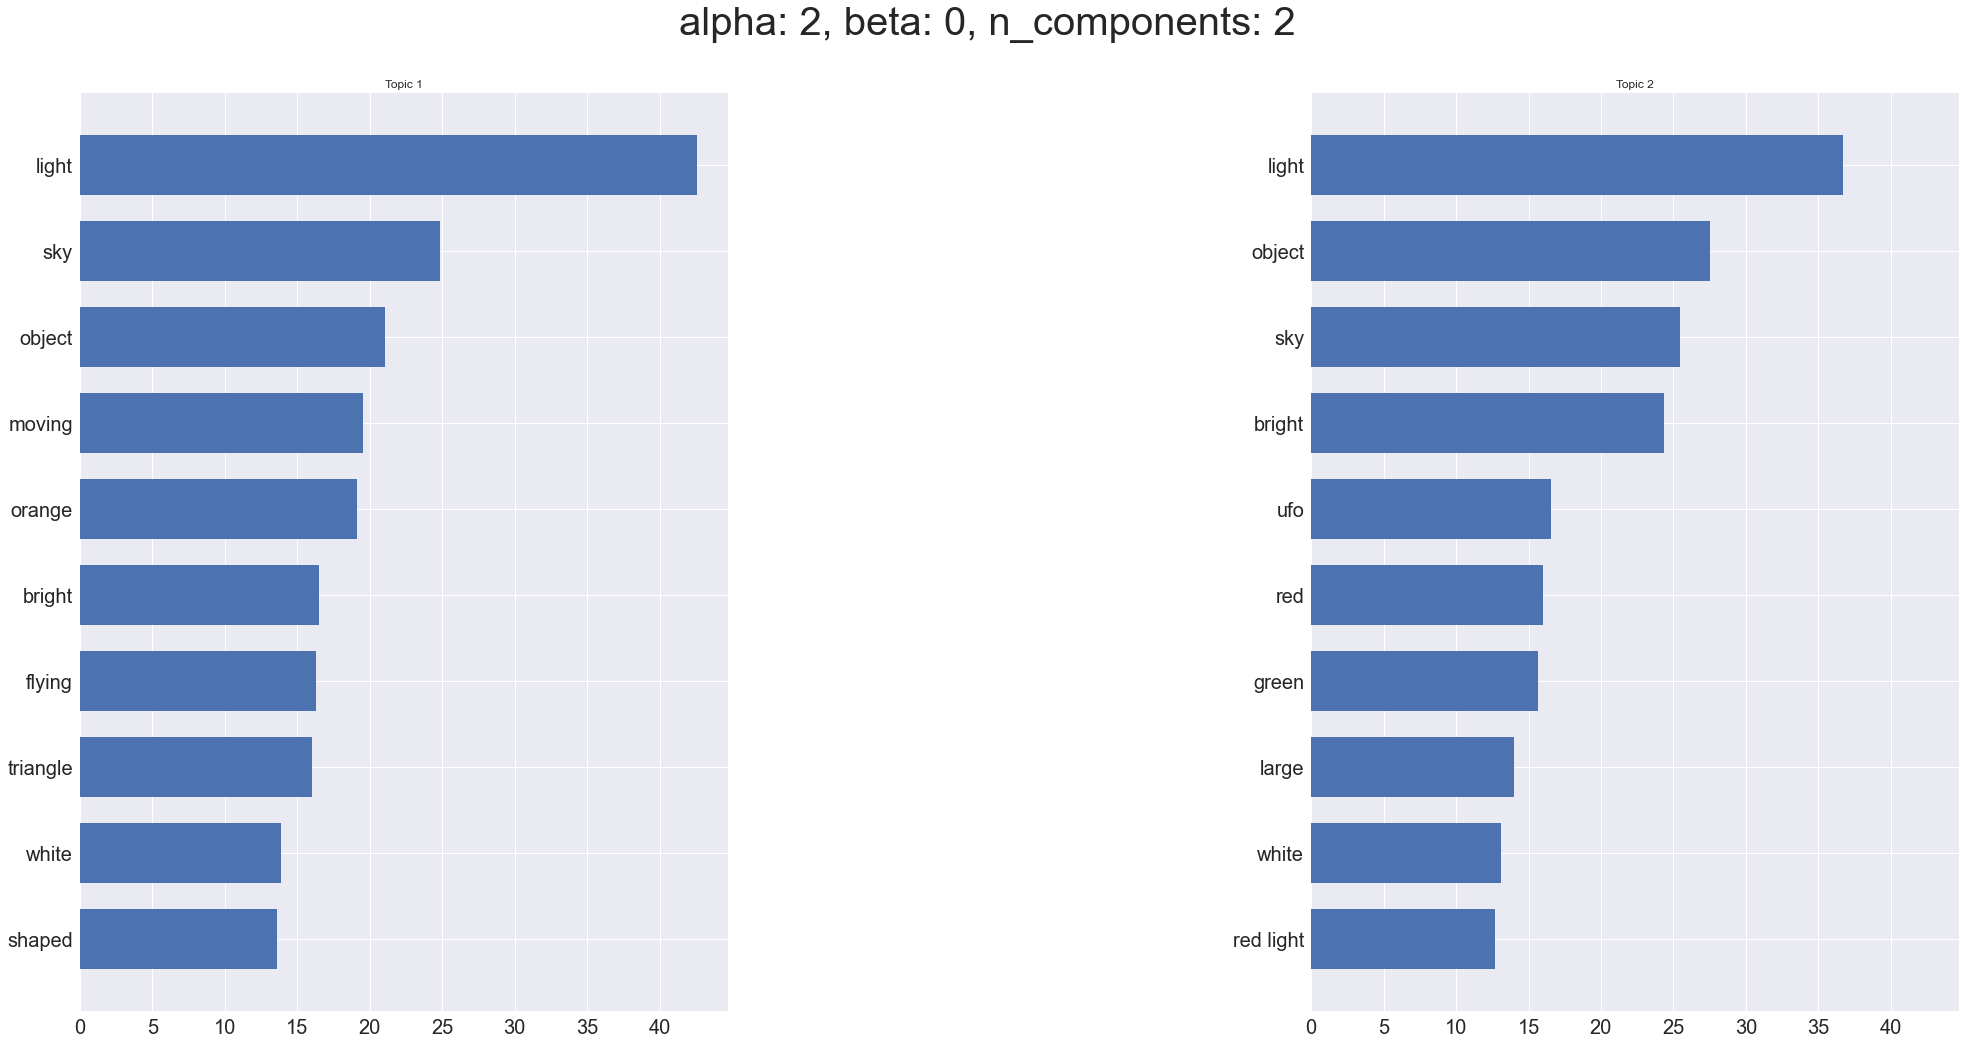

In [160]:
# model with highest perplexity score from bigram model
plot_best_model_from_trials(trials, tfidf_bigrams)

In [161]:
tfidf = TfidfVectorizer(ngram_range=(2,4))
X = tfidf.fit_transform(small_train_df.cleaned_summary)
X_test = tfidf.transform(small_test_df.cleaned_summary)
feature_names = tfidf.get_feature_names_out()
trials = run_trials(X, X_test, tfidf)
pd.DataFrame(trials, columns = ['alpha', 'beta', 'n_components', 'perplexity']).sort_values('perplexity')

,alpha,beta,n_components,perplexity
71,2.00,0.50,10,2.019835e+05
59,2.00,0.50,7,2.050921e+05
47,2.00,0.50,5,2.099004e+05
35,2.00,0.50,4,2.142960e+05
23,2.00,0.50,3,2.215146e+05
...,...,...,...,...
36,0.01,0.01,5,4.454503e+39
51,0.10,0.01,7,9.976937e+39
48,0.01,0.01,7,2.175832e+40
63,0.10,0.01,10,4.561411e+40


C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:745: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:746: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))


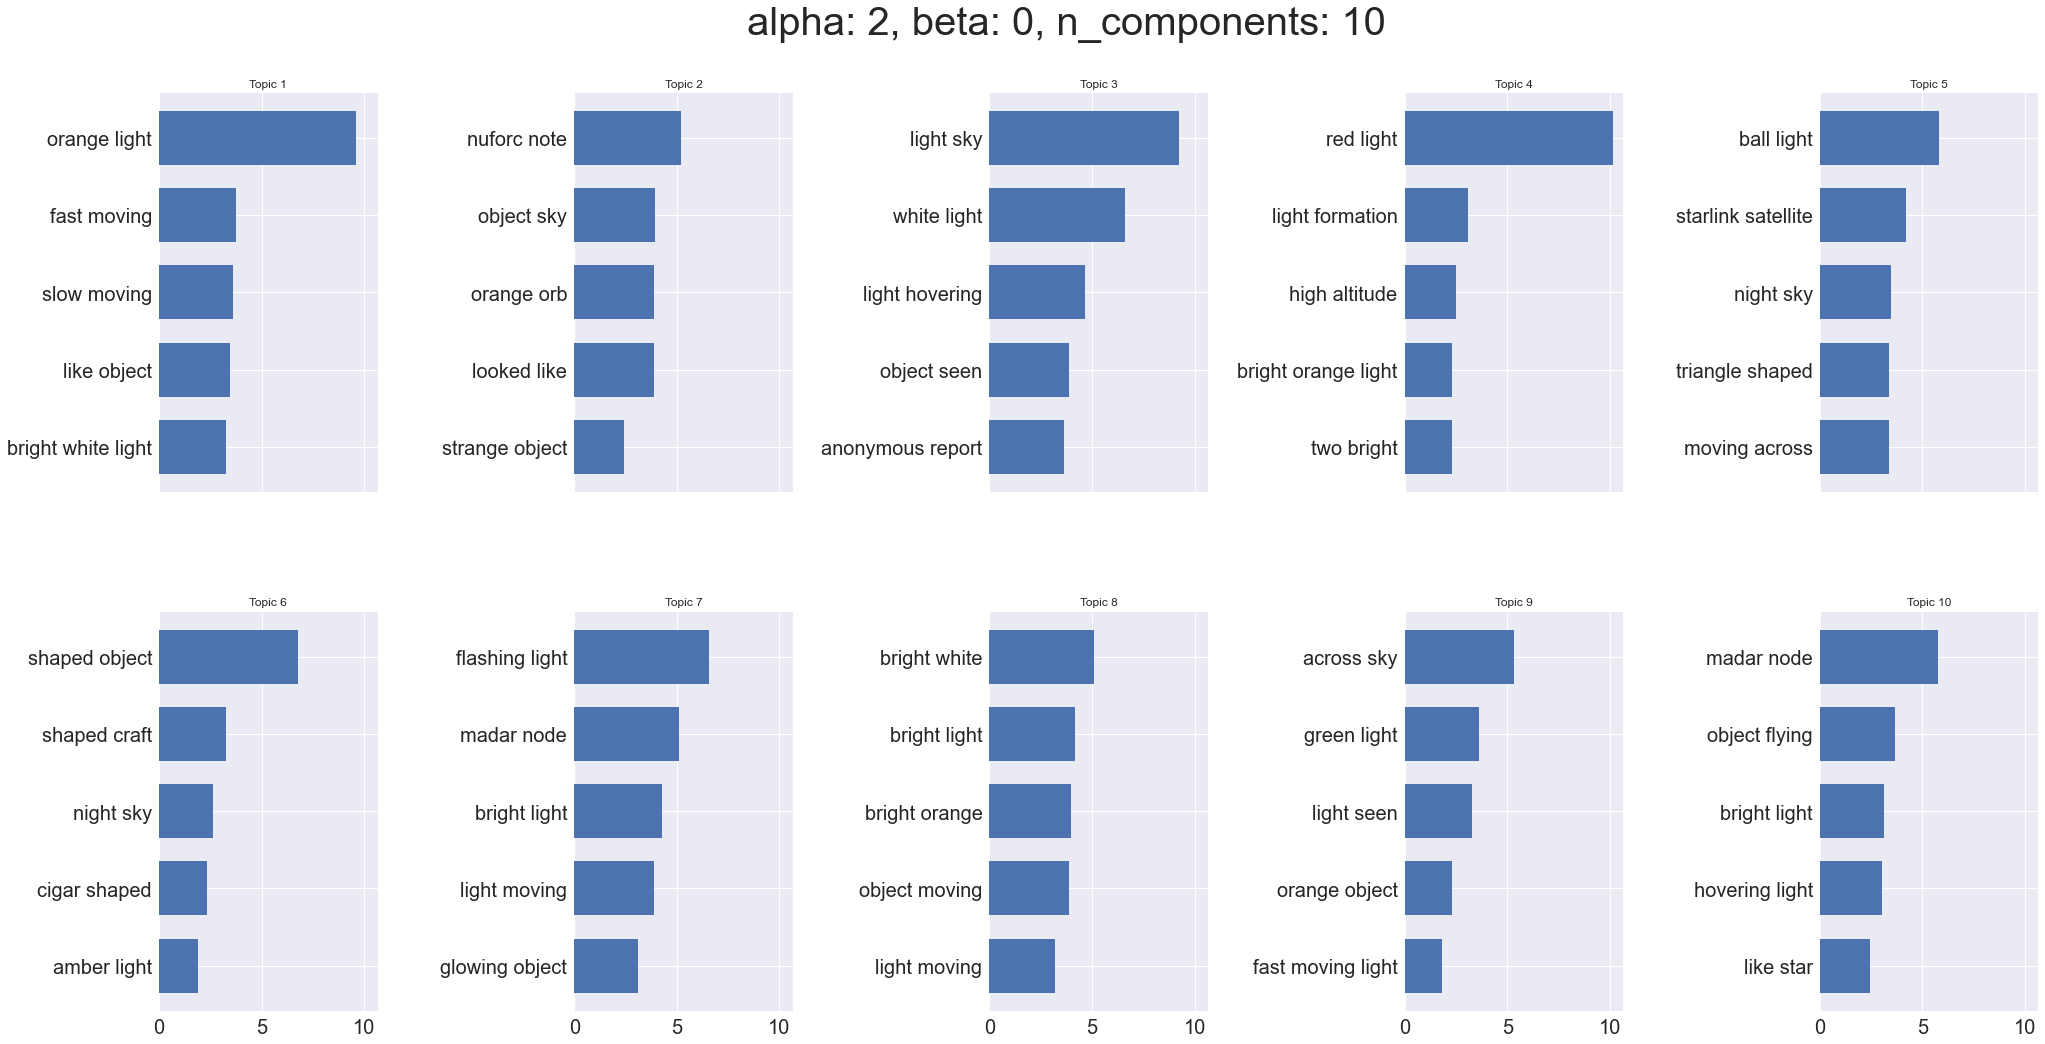

In [164]:
# model with highest perplexity score from bigram model
plot_best_model_from_trials(trials, tfidf)

### Now the model with the lowest perplexity has 10 topics. Extend range of trials and run on entire dataset:

In [16]:
X, X_test = train_test_split(df.cleaned_summary.sample(100), shuffle=True, random_state=42,test_size=0.2)
tfidf = TfidfVectorizer(ngram_range=(2,3))
X = tfidf.fit_transform(X)
X_test = tfidf.transform(X_test)
feature_names = tfidf.get_feature_names_out()
trials = run_trials(X, X_test, tfidf, n_topics=list(range(10, 12, 1)))
pd.DataFrame(trials, columns = ['alpha', 'beta', 'n_components', 'perplexity']).sort_values('perplexity')

NameError: name 'run_trials' is not defined

C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:745: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:746: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))


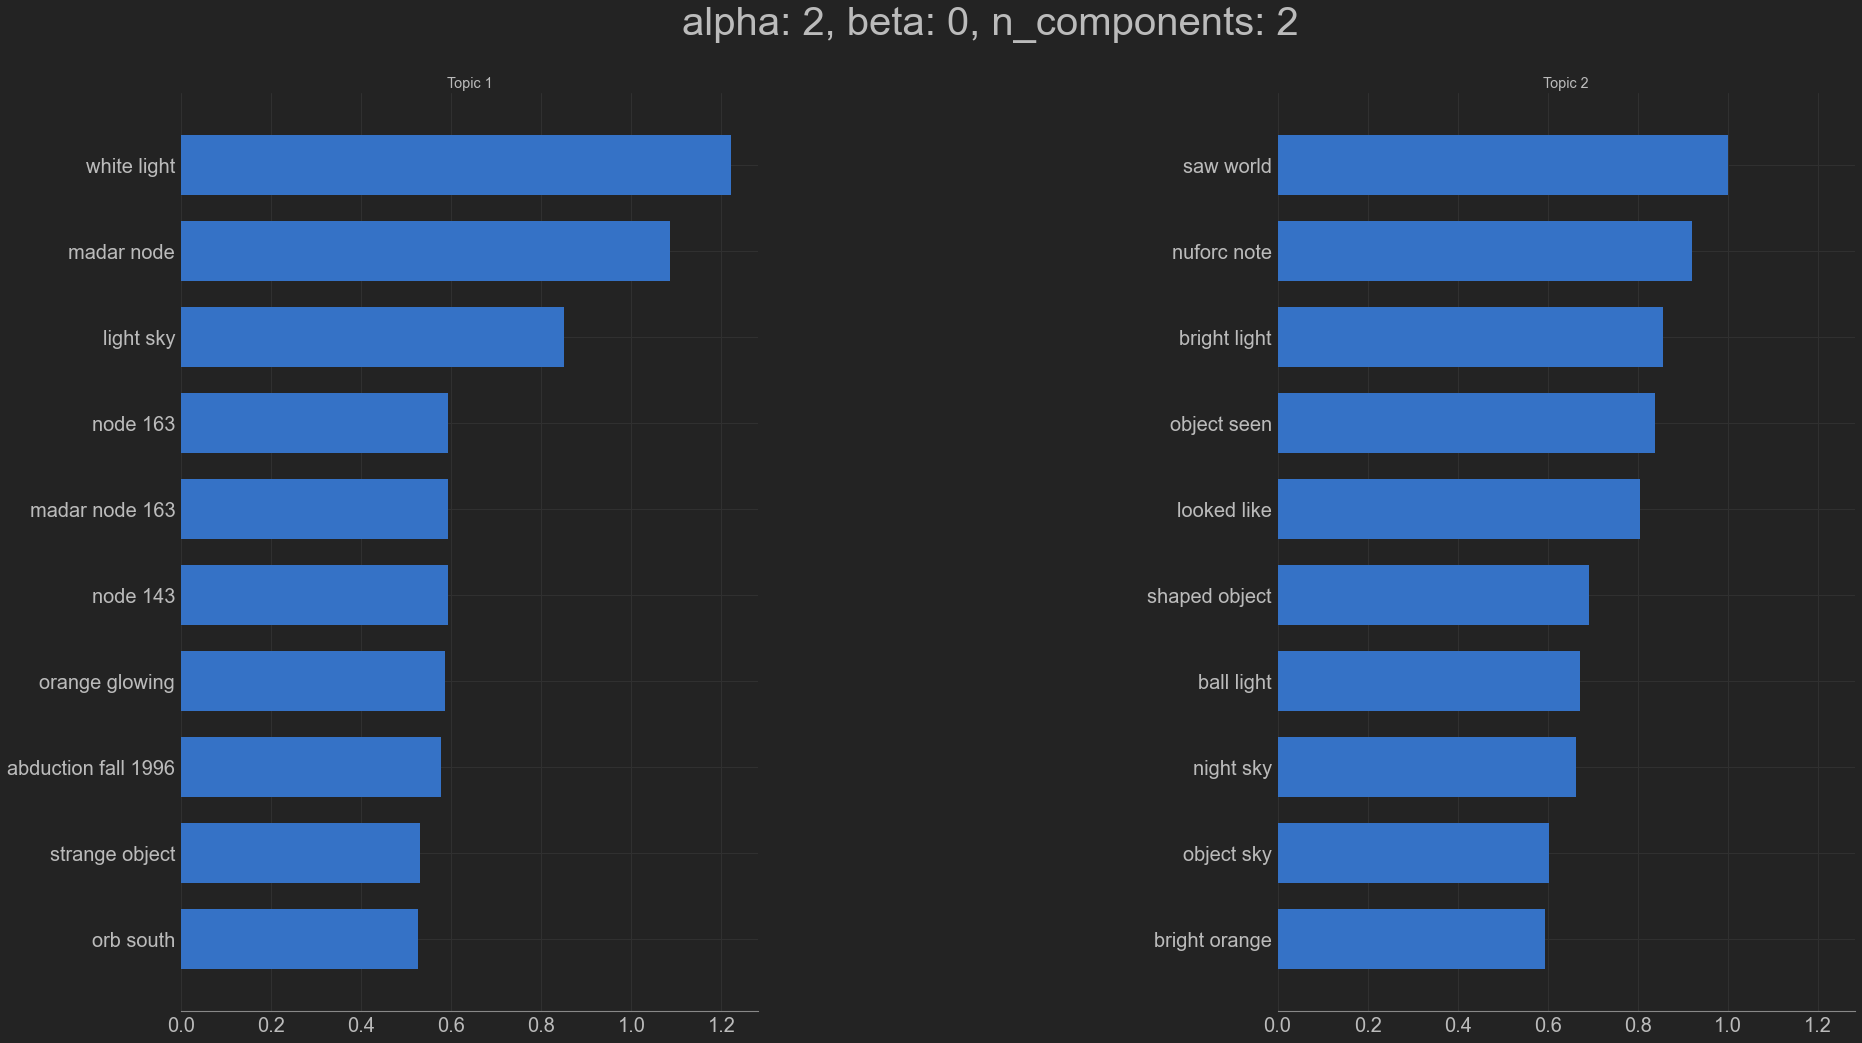

C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:745: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:746: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))


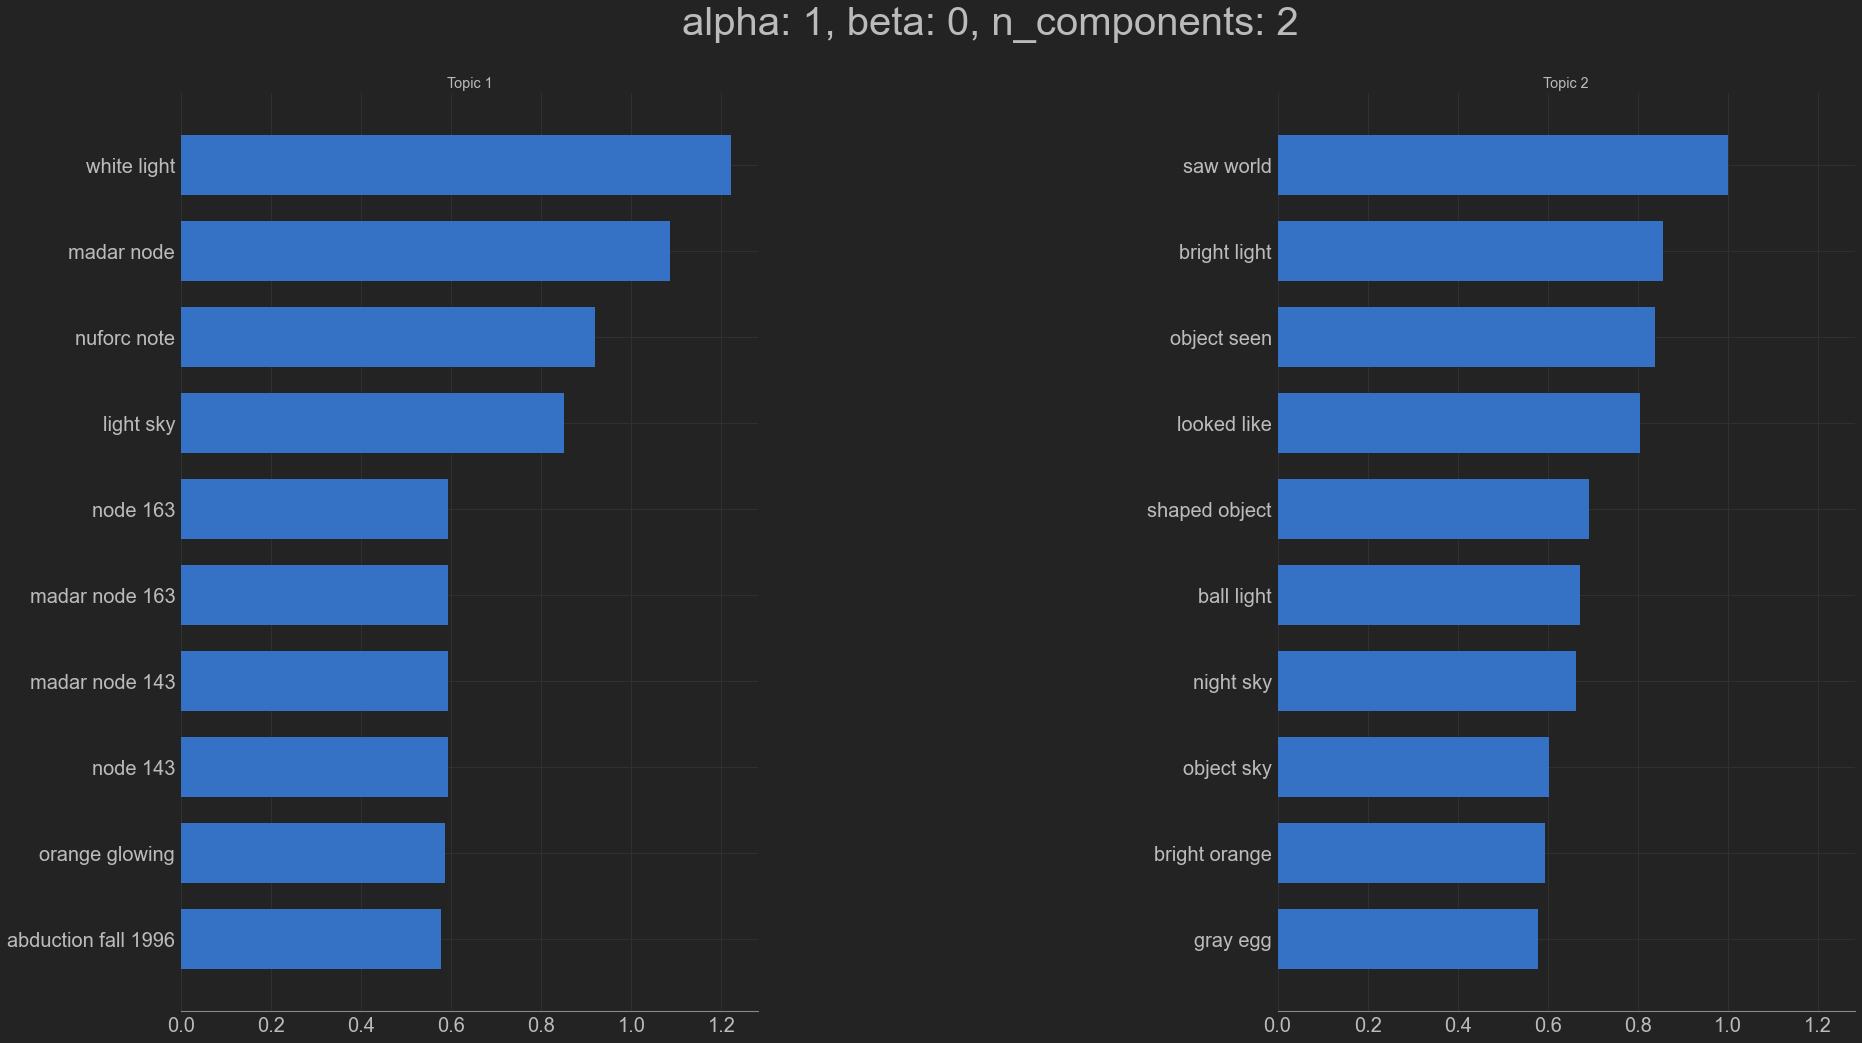

C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:745: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:746: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))


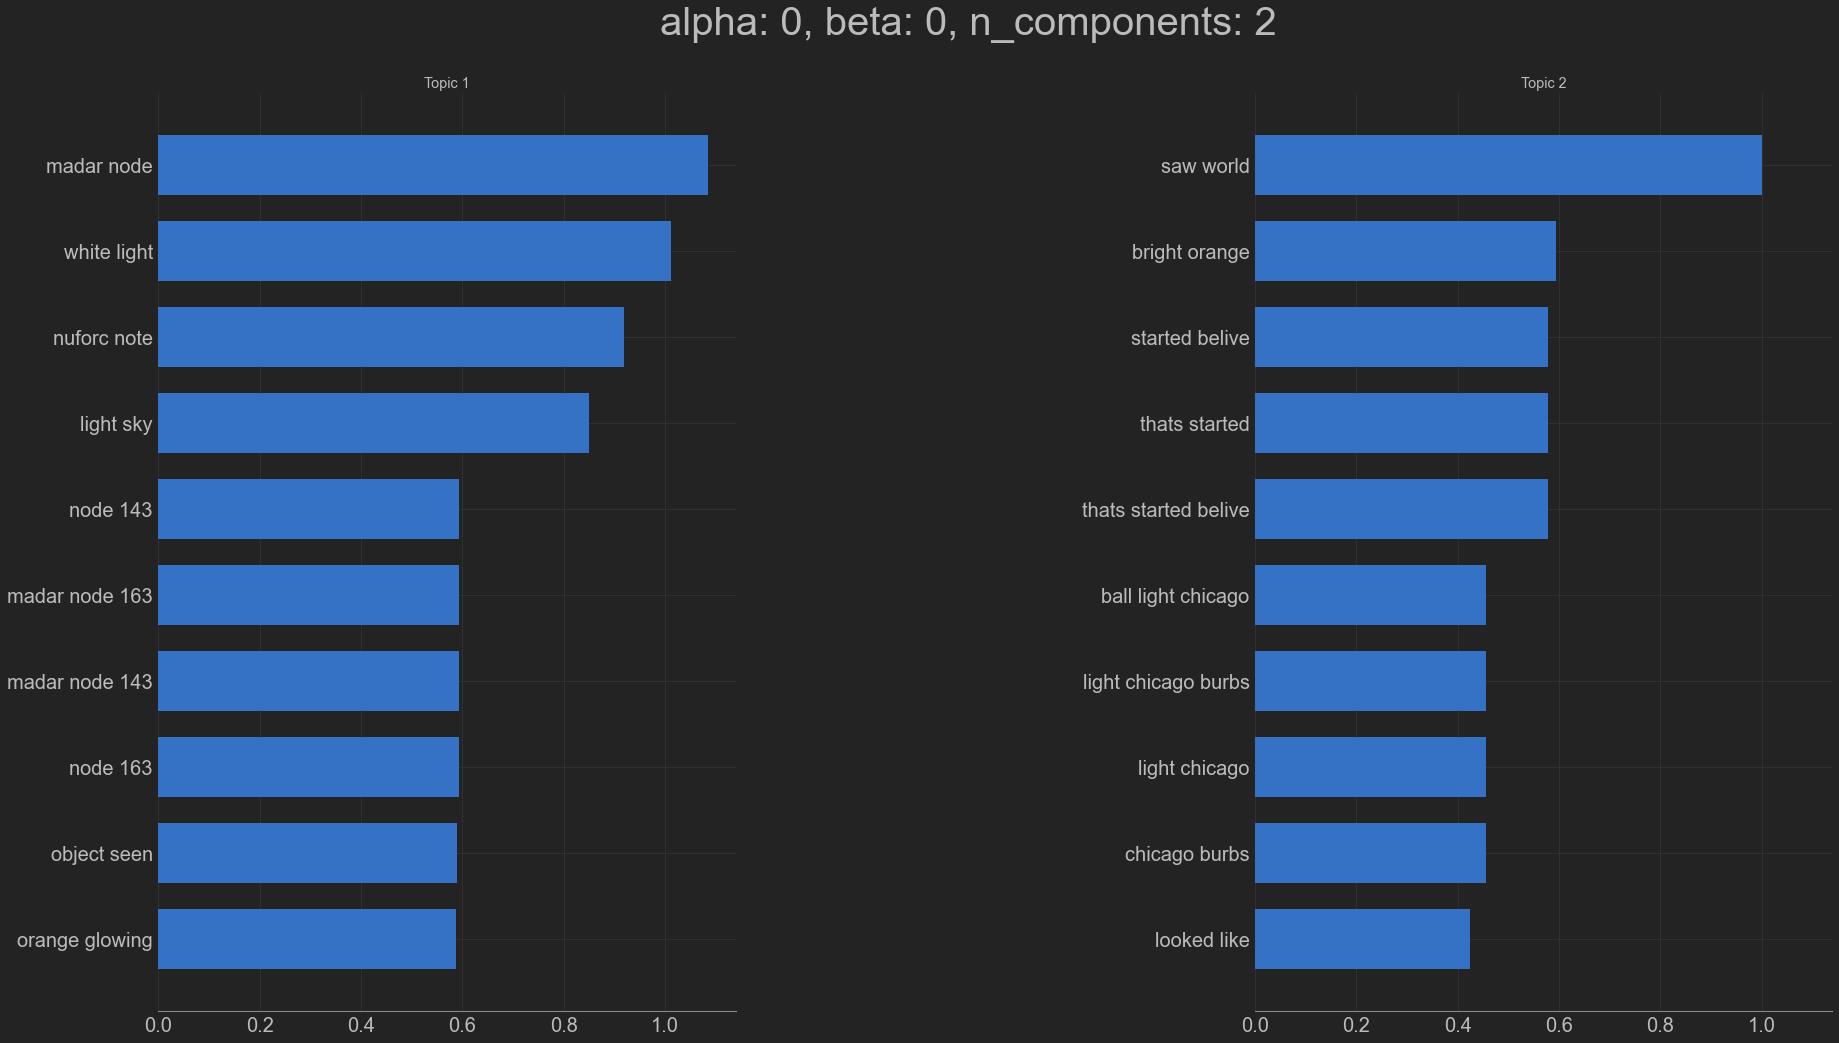

In [17]:
# model with highest perplexity score from bigram model
plot_best_model_from_trials(trials, tfidf)

In [ ]:
X, X_test = train_test_split(df.cleaned_summary, shuffle=True, random_state=42, test_size=0.2)
tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words=['bright', 'light'])
X = tfidf.fit_transform(X)
X_test = tfidf.transform(X_test)
feature_names = tfidf.get_feature_names_out()
trials = run_trials(X, X_test, tfidf, alphas=[1,2,3], betas=[0.01, 0.1], n_topics=list(range(6,12,2)))
pd.DataFrame(trials, columns = ['alpha', 'beta', 'n_components', 'perplexity']).sort_values('perplexity')

In [ ]:
plot_best_model_from_trials(trials, tfidf)

# HDP

In [62]:
#!pip install tomotopy

     ---------------------------------------- 5.7/5.7 MB 4.5 MB/s eta 0:00:00


In [8]:
import tomotopy as tp

HDPModel(tw=TermWeight.ONE, min_cf=0, min_df=0, rm_top=0, initial_k=2, alpha=0.1, eta=0.01, gamma=0.1, seed=None, corpus=None, transform=None)

In [31]:
k = 9
model = tp.LDAModel(seed=42, k=k, rm_top=1)
for line in df.cleaned_summary:
    model.add_doc(line.strip().split())

#model.set_word_prior('bright', [1.0 if k == 0 else 0.1 for k in range(k)])
#model.set_word_prior('light', [1.0 if k == 0 else 0.1 for k in range(k)])

for i in range(0, 500, 10):
    model.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, model.ll_per_word))

model.summary()

C:\Users\Connor\AppData\Local\Temp\ipykernel_17832\3172075221.py:10: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10)


Iteration: 0	Log-likelihood: -8.505527376471644
Iteration: 10	Log-likelihood: -8.269301737102635
Iteration: 20	Log-likelihood: -8.059356784511252
Iteration: 30	Log-likelihood: -7.942965268016799
Iteration: 40	Log-likelihood: -7.874734385285459
Iteration: 50	Log-likelihood: -7.828983295543586
Iteration: 60	Log-likelihood: -7.801102821887221
Iteration: 70	Log-likelihood: -7.783535278661246
Iteration: 80	Log-likelihood: -7.769221644403989
Iteration: 90	Log-likelihood: -7.757012111366815
Iteration: 100	Log-likelihood: -7.746105692994967
Iteration: 110	Log-likelihood: -7.737373479203756
Iteration: 120	Log-likelihood: -7.728941699738704
Iteration: 130	Log-likelihood: -7.723698635432356
Iteration: 140	Log-likelihood: -7.716085020915131
Iteration: 150	Log-likelihood: -7.710678356172793
Iteration: 160	Log-likelihood: -7.704991804769916
Iteration: 170	Log-likelihood: -7.701685944108563
Iteration: 180	Log-likelihood: -7.697158703737674
Iteration: 190	Log-likelihood: -7.691353119204583
Iteration: 

In [9]:
from nltk import ngrams, word_tokenize

def generate_bigrams(text):
    tokens = word_tokenize(text)  
    bigrams = list(ngrams(tokens, 2)) 
    return bigrams

df['cleaned_summary'].sample(100).apply(generate_bigrams)

108234    [(12, orange), (orange, orb), (orb, appearing)...
110327    [(hoax, 2), (2, bright), (bright, light), (lig...
47837     [(video, proof), (proof, jet), (jet, match), (...
136852    [(exactly, said), (said, went), (went, swiftly...
110345    [(starting, take), (take, walk), (walk, 615), ...
                                ...                        
115238    [(defined, bright), (bright, glowing), (glowin...
125804    [(soon, started), (started, get), (get, exit),...
31594     [(aprox, 30), (30, disk), (disk, shaped), (sha...
86752     [(main, craft), (craft, strange), (strange, pl...
404       [(ball, white), (white, light), (light, darted...
Name: cleaned_summary, Length: 100, dtype: object

In [10]:
from gensim.models.phrases import Phrases, Phraser

sentences = list(df.cleaned_summary.apply(lambda x: x.split()))
phrases = Phrases(sentences, min_count=10, max_vocab_size=80000000, threshold=10)
phraser = Phraser(phrases)

model = tp.HDPModel(seed=42, min_df=1000, rm_top=7)
for line in sentences:
    model.add_doc(phraser[line])

#model.set_word_prior('bright', [1.0 if k == 0 else 0.1 for k in range(k)])
#model.set_word_prior('light', [1.0 if k == 0 else 0.1 for k in range(k)])

for i in range(0, 100, 10):
    model.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, model.ll_per_word))

model.summary()

C:\Users\Connor\AppData\Local\Temp\ipykernel_10800\1802865990.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10)


Iteration: 0	Log-likelihood: -4.991820188523911
Iteration: 10	Log-likelihood: -4.96841425809549
Iteration: 20	Log-likelihood: -4.9666687042550075
Iteration: 30	Log-likelihood: -4.96736961185655
Iteration: 40	Log-likelihood: -4.9707792869688765
Iteration: 50	Log-likelihood: -4.979307507256947
Iteration: 60	Log-likelihood: -4.989167014788478
Iteration: 70	Log-likelihood: -4.990025470927992
Iteration: 80	Log-likelihood: -4.994143676697839
Iteration: 90	Log-likelihood: -5.000896149159508
<Basic Info>
| HDPModel (current version: 0.12.4)
| 141223 docs, 442863 words
| Total Vocabs: 53816, Used Vocabs: 158
| Entropy of words: 4.83109
| Entropy of term-weighted words: 4.83109
| Removed Vocabs: light sky object bright moving white saw
|
<Training Info>
| Iterations: 100, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -5.00090
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 1000 (minimum document frequency of word

In [24]:
topics = []
for i, doc in enumerate(model.docs):
    topic_dist = doc.get_topic_dist()
    main_topic_id = np.argmax(topic_dist)
    topics.append(main_topic_id)

In [41]:
df = df.drop(df[df.cleaned_summary == ''].index).reset_index()
df = df.assign(topic=pd.Series(topics))

In [44]:
df = df.drop(columns='index')
df

,summary,country,city,state,date_time,shape,duration,stats,report_link,text,...,is_weekend,duration_num,duration_unit,duration_multiplier,duration_seconds,log_duration_sec,binned_log_duration,cleaned_text,cleaned_summary,topic
0,MADAR Node 100,USA,Mountlake Terrace,Other,2019-06-23 18:53:00,NaN,NaN,Occurred : 6/23/2019 18:53 (Entered as : 06/2...,http://www.nuforc.org/webreports/reports/147/S...,MADAR Node 100,...,True,NaN,minutes,60.0,NaN,NaN,NaN,madar node 100,madar node 100,13
1,Steady flashing object with three lights hover...,USA,Hamden,Other,2019-06-23 20:00:00,light,5 hours,Occurred : 6/23/2019 20:00 (Entered as : 6/23...,http://www.nuforc.org/webreports/reports/147/S...,Steady flashing object with three lights hover...,...,True,5.0,hours,3600.0,18000.0,4.255273,3.0,steady flashing object three light hovered sky...,steady flashing object three light hovered sky,1
2,"Group of several orange lights, seemingly circ...",USA,Charlottesville,Other,2019-06-20 23:28:00,circle,15 seconds,Occurred : 6/20/2019 23:28 (Entered as : 06/2...,http://www.nuforc.org/webreports/reports/146/S...,"Group of several orange lights, seemingly circ...",...,False,15.0,seconds,1.0,15.0,1.176091,0.0,group several orange light seemingly circular ...,group several orange light seemingly circular ...,1
3,Dropped in flashed a few times and shot off 5 ...,USA,Lincoln Park,Other,2019-06-21 00:00:00,light,2 minutes,Occurred : 6/21/2019 00:00 (Entered as : 06/2...,http://www.nuforc.org/webreports/reports/146/S...,Dropped in flashed a few times and shot off 5 ...,...,False,2.0,minutes,60.0,120.0,2.079181,1.0,dropped flashed time shot 5 6 ball light shot ...,dropped flashed time shot 5 6 ball light shot ...,1
4,"Location: While traveling in a TGV, from Lille...",Other,Douai (France),Other,2019-06-07 20:00:00,cigar,5 minutes,Occurred : 6/7/2019 20:00 (Entered as : 06/07...,http://www.nuforc.org/webreports/reports/146/S...,"Location: While traveling in a TGV, from Lill...",...,False,5.0,minutes,60.0,300.0,2.477121,2.0,location traveling tgv lille charles du gaule ...,location traveling tgv lille charles du gaule ...,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141218,See craft every evening when I get out of work...,USA,Branford,Other,2021-12-19 23:00:00,circle,NaN,Occurred : 12/19/2021 23:00 (Entered as : 12/...,http://www.nuforc.org/webreports/reports/165/S...,See craft every evening when I get out of work...,...,True,NaN,minutes,60.0,NaN,NaN,NaN,see craft every evening get work follows home ...,see craft every evening get work follows home,0
141219,MADAR Node 70,USA,St Louis,Other,2022-03-09 00:48:00,NaN,NaN,Occurred : 3/9/2022 00:48 (Entered as : 03/09...,http://www.nuforc.org/webreports/reports/167/S...,MADAR Node 70 \n \n,...,False,NaN,minutes,60.0,NaN,NaN,NaN,madar node 70,madar node 70,13
141220,A very small white light hovering above the cl...,USA,Batavia,Other,2013-04-30 02:19:00,circle,45 seconds,Occurred : 4/30/2013 02:19 (Entered as : 04/3...,http://www.nuforc.org/webreports/reports/097/S...,A very small white light hovering above the cl...,...,False,45.0,seconds,1.0,45.0,1.653213,1.0,small white light hovering cloud decended upon...,small white light hovering cloud decended upon...,0
141221,I was young. You know what? It was pretty fuck...,USA,Liberty Lake,Other,1995-07-21 09:00:00,circle,1/12,Occurred : 7/21/1995 09:00 (Entered as : 07/2...,http://www.nuforc.org/webreports/reports/151/S...,I was young. You know what? It was pretty ((...,...,False,1.0,None,NaN,NaN,NaN,NaN,young know pretty deleted memorable u wanna kn...,young know pretty fucking memorable u wanna kn...,0


In [23]:
for g, d in pd.read_pickle('with_topics.pickle').groupby('topic').summary:
    print(f'Topic #{g}')
    for line in d.sample(5, replace=True):
        print(line)

Topic #0
Cigar/Rod shaped object rotating silently in the sky
Midtown Tulsa Oklahoma:witnessed one bright ball of light high in the night sky. Looked up to notice the beauty of the moon lit clouds
I was outside and saw a blue light in the sky
Question over what i saw.
Ball of fire observed in sky.
Topic #1
Oval object travelling North West in sky with flashing lights.
Trapezoidal shape  UFO above high voltage power cables.
A round light in the sky hovered then moved in a perfect line from one point to another and disappeared
I was at work doing my normal thing of picking up small pieces of trash around an apartment complex. About 3 or 4 times a week, I hear
Strange lights in the fog.
Topic #2
Driving truck along I-80 west when i noticed the truck that had just passed me swirve from the outside lain to the inside lain then bac
I was driving by the airport like i do everyday and saw 3 red lights at tree level that have never been there before
Made no sound and flew right above our heads 

In [14]:
topics = []

for s in sentences:
    try:
        d = model.make_doc(phraser[s])
    except:
        topics.append(-1)
        continue
    pred, ll = model.infer(d)
    topics.append(pred)
    

NameError: name 'sentences' is not defined

In [15]:
df['topics'] = topics
df.topics.value_counts()

ValueError: Length of values (0) does not match length of index (141261)

In [ ]:
len(topics)

In [100]:
# try spacy's tokeniser
import spacy
nlp = spacy.load("en_core_web_sm")
def tokeniser(string):
    return nlp(string)

df.cleaned_summary.sample(100).apply(tokeniser)

73032     (bright, oval, craft, made, noise, moved, quic...
50061                                        (may, concern)
127113    (driving, lem, turner, rd, past, 1230am, going...
121278    (high, alt, excess, 30000, ft, creeping, aroun...
54219     (three, people, see, illuminated, v, shaped, o...
                                ...                        
82984     (three, flashing, red, light, triangle, format...
31048     (saw, diskshaped, craft, blinking, light, colo...
101232    (traveling, store, brock, avenue, noticed, whi...
55379     (object, shaped, like, teardrop, side, flying,...
36936     (flightline, kirtland, afb, looking, west, ext...
Name: cleaned_summary, Length: 100, dtype: object

In [11]:
for s in sentences[:4]:
    print(phraser[s])

NameError: name 'sentences' is not defined

In [56]:
for i, doc in enumerate(df['cleaned_summary']):
    topic_dist = model.ge
    topics = ', '.join([str(topic[0]) for topic in topic_dist])
    df.at[i, 'topics'] = topics

AttributeError: 'tomotopy.HDPModel' object has no attribute 'get_topics'

# Clustering

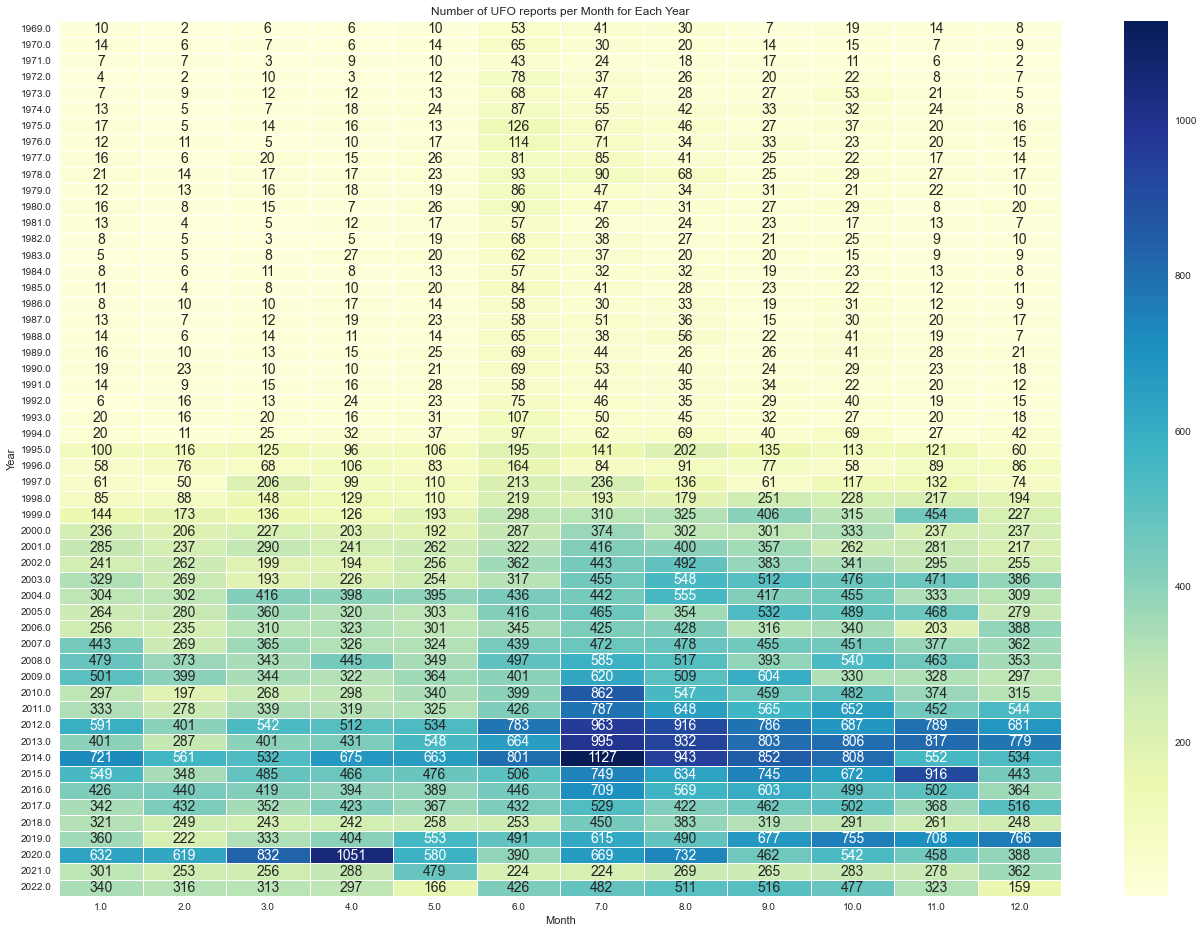

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

counts = df.groupby(['year', 'month']).size().unstack()


plt.figure(figsize=(20, 15))
sns.heatmap( counts, cmap='YlGnBu', linewidths=.5, annot=True, fmt=".0f", cbar=True)
plt.title('Number of UFO reports per Month for Each Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


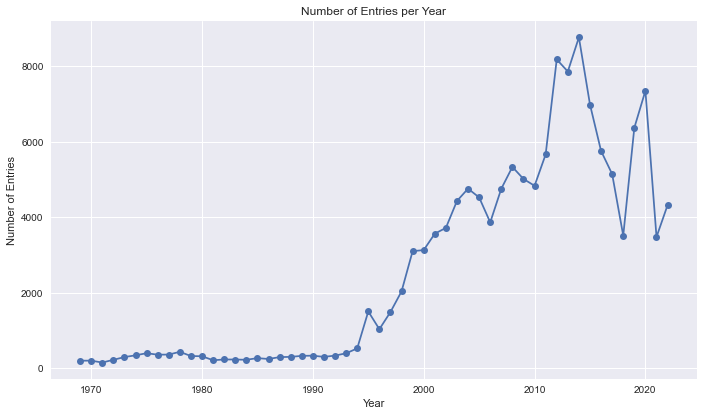

In [222]:

yearly_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))  # Change the size as needed
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.grid(True)
plt.title('Number of Entries per Year')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.tight_layout()
plt.show()
